## Single member capacity
emma.lejeune.11@gmail.com

The objective of this Jupyter notebook is to compute the capacity of a single member subject to axial compression and bending loads. 

We consider a single member with cylindrical cross section defined as:

<p align="left">
<img src="cross_section.jpeg" width="100">
</p>

We consider the following four loading scenario superimposed into one "worst-case scenario" design load: 

<p align="left">
<img src="design_load.jpeg" width="500">
</p>

The **inputs** to this analysis script are: parameters r<sub>1</sub> and r<sub>2</sub> that define the geometry of the section

The **output** of this analysis script is: (1) a plot to check if the loading assumptions exceed the capacity of the member in bending, and (2) a plot of maximum allowable axial stress P<sub>axial</sub><sup>max</sup> with respect to memeber length. 

The (sort of empirical) formula used to compute P<sub>axial</sub><sup>max</sup> accounts for buckling, bending, yielding, and the nonlinear interaction between them (referred to as a P-δ effect, this is the empirical part of the analysis). This analysis will be used to rule out sections that are unequivocally too small (e.g., unable to support just the weight of one person hanging on it), and compared to the outputs of the linear structural analysis to aid in final section selection. 


In [81]:
import numpy as np
import matplotlib.pyplot as plt 
# Use units of kg, m, Pa, s

# Section geometric properties (inputs) 
# https://www.engineeringtoolbox.com/asme-steel-pipes-sizes-d_42.html
# a few schedule 40 options
# nominal 1 " inner diameter = 26.645, and thickness = 3.378
# nominal: 1 1/4 " inner diameter = 35.052, and thickness = 3.556
# nominal: 1 1/2 " inner diameter = 40.894, and thickness = 3.683
# nominal: 2 "  inner diameter = 52.501, and thickness = 3.912
nominal_info = 'nominal_1_25' # ************* CHANGE THIS (label plots)
r1_mm =  35.052/2.0 # mm ******************** CHANGE THIS ************
r2_mm = 35.052/2.0 + 3.556 # mm ************ CHANGE THIS ************
r1 = r1_mm / 1000 # m
r2 = r2_mm / 1000 # m 
L_min = 0.5 # m (minimum considered member length)
L_max = 3.0 # m (maximum considered member length)

# Section geometric properties (computed from inputs)
A = np.pi*r2**2.0 - np.pi*r1**2.0 # m^2
I = np.pi*r2**4.0/4.0 - np.pi*r1**4.0/4.0 # m^4
S = I / r2 # m^3
Rg = (I / A)**0.5 # m

# Steel material properties 
rho_steel_kg_m3 = 7850 # kg / m^3
gravity = 9.81 # m / s^2
E_steel_GPa = 200 # GPa
E = E_steel_GPa * 10**9.0 # Pa 
sigma_yield_steel_MPa = 350 # MPa
sy = sigma_yield_steel_MPa * 10**6.0 #Pa

# design coefficients
dead_load_factor = 1.2 
live_load_factor = 1.6 
resistance_factor = 0.9

# Gravity line load 
self_wt_distributed = gravity * rho_steel_kg_m3 * A * dead_load_factor # N / m 

# Live load 
mass_one_person = 100 # kg 
number_of_people = 1.0
P_live = mass_one_person * number_of_people * gravity * live_load_factor # N 

# Wind load (approximate)
r2_feet = 3.28084 * r2
wind_speed = 115 # mph
c_d = 1.2 
wind_distributed_lbs = r2_feet * 2.0 * 0.00256 * wind_speed ** 2.0 * c_d
wind_distributed = wind_distributed_lbs * 4.4482216153


Text(0.5, 1.0, 'does bending capacity meet demand? -- all loads')

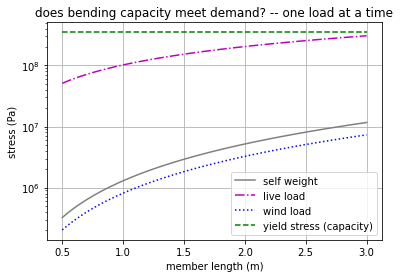

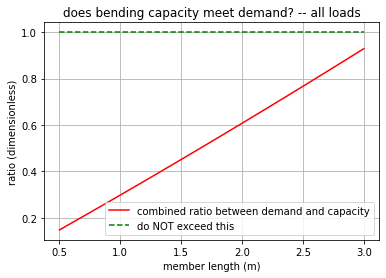

In [82]:
# Check the bending load case for multiple member lengths 
L = np.linspace(L_min,L_max) # m 

M_max_self_wt = self_wt_distributed * L ** 2.0 / 8.0 # N * m 
sb_self_wt = M_max_self_wt / S # N / m^2

M_max_live = P_live * L / 4.0 # N * m 
sb_live = M_max_live / S # N / m^2

M_max_wind = wind_distributed * L ** 2.0 / 8.0 # N * m 
sb_wind = M_max_wind / S # N / m^2 

plt.figure()
plt.semilogy(L,sb_self_wt,'-',color=(.5,.5,.5),label='self weight')
plt.semilogy(L,sb_live,'m-.',label='live load')
plt.semilogy(L,sb_wind,'b:',label='wind load')
plt.semilogy([L_min,L_max],[sy,sy],'g--',label='yield stress (capacity)')
plt.xlabel('member length (m)'); plt.ylabel('stress (Pa)')
plt.legend()
plt.grid(True)
plt.title('does bending capacity meet demand? -- one load at a time')

# combined loading case
demand_y = sb_self_wt + sb_live
demand_z = sb_wind
capacity_y = sy
capacity_z = sy 

ratio = demand_y / capacity_y + demand_z / capacity_z

plt.figure()
plt.plot(L,ratio,'r',label='combined ratio between demand and capacity')
plt.plot([L_min,L_max],[1,1],'g--',label='do NOT exceed this')
plt.legend()
plt.xlabel('member length (m)'); plt.ylabel('ratio (dimensionless)')
plt.grid(True)
plt.title('does bending capacity meet demand? -- all loads')

### Eqn. H1-1 (combined axial compression and bending) will likely dictate the axial capacity of a single member (P<sub>axial</sub><sup>max</sup>)

For combined axial compression and bending, we will refer to the AISC Steel Construction Manual: 

<p align="left">
<img src="combined_eqn.png" width="500">
</p>

See: https://www.aisc.org/globalassets/aisc/manual/15th-ed-ref-list/specification-for-structural-steel-buildings-allowable-stress-design-and-plastic-design.pdf

Capacity = 4.167e+04 N for a 1m member with k = 1
Capacity = 41.7 kN for a 1m member with k = 1


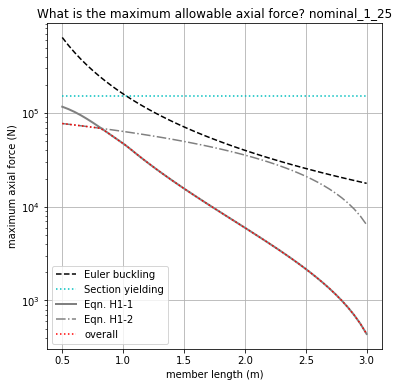

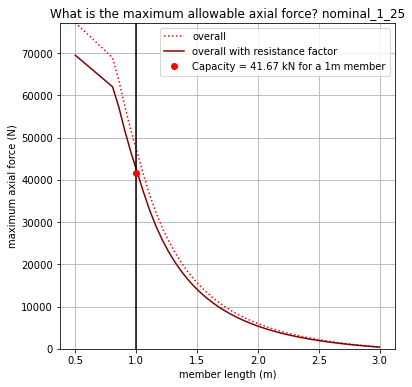

In [85]:
# compute the capacity based on Euler buckling 
k = 1.0 # for pin-pin connection, would use 2.0 for pin-free
P_axial_max_Euler = np.pi ** 2.0 * E * I / (k * L ) ** 2.0 

# compute the capacity based on axial yielding (not length dependant)
P_axial_yield = sy * A * np.ones(L.shape[0])

# compute the capacity based on eqn H1-2 
# i.e., set H1-2 = 1, solve for f_a (stress) and convert it into a force 
Fy = sy
fbx = demand_y # (see previous cell for computing bending demand -- apologies for confusing notation here -- just getting everything to match H1-2)
Fbx = capacity_y
fby = demand_z
Fby = capacity_z
fa = (1.0 - (fbx/Fbx + fby/Fby) ) * 0.6 * Fy
P_axial_H12 = fa * A 

# compute the capacity based on eqn H1-1 
# i.e., set H1-1 = 1, solve for f_a (stress) and convert it into a force
Cmx = 1.0 # coefficient from the manual
Cmy = Cmx # symmetry
Fex_prime = 12.0 * np.pi ** 2.0 * E / (23.0 * (k * L / Rg) ** 2.0) # this formula comes directly from the manual 
Fey_prime = Fex_prime # symmetry 
Fa_euler = P_axial_max_Euler / A  
Fa_yield = sy 
# this is a quadratic equation -- just manipulating it to solve
b_all = Cmx * fbx / Fbx
c_all = Fex_prime
d_all = Cmy * fby / Fby 
sig_axial_H11 = []
for zz in range(0,L.shape[0]):
    a = np.min([Fa_euler[zz],Fa_yield])
    b = b_all[zz]
    c = c_all[zz]
    d = d_all[zz]
    p0 = -1.0 / c 
    p1 = ( 1.0 + a / c)
    p2 = (b + d)*a - a 
    roots = np.roots([p0,p1,p2])
    if np.min(roots) < 0:
        sig_axial_H11.append(0)
    else:
        ix = np.argmin(np.abs(roots))
        sig_axial_H11.append(roots[ix])

P_axial_H11 = np.asarray(sig_axial_H11) * A 

P_axial_overall = []
for zz in range(0,L.shape[0]):
    P_axial_overall.append(np.min([P_axial_max_Euler[zz],P_axial_yield[zz],P_axial_H11[zz],P_axial_H12[zz] ]))

P_axial_overall = np.asarray(P_axial_overall)

# plot results -- this shows all equations
plt.figure(figsize=(6,6))
plt.semilogy(L,P_axial_max_Euler,'k--',label='Euler buckling')
plt.semilogy(L,P_axial_yield,'c:',label='Section yielding')
plt.semilogy(L,P_axial_H11,color=(.5,.5,.5),linewidth=2,label='Eqn. H1-1')
plt.semilogy(L,P_axial_H12,'-.',color=(.5,.5,.5),label='Eqn. H1-2')
plt.semilogy(L,P_axial_overall,'r:',label='overall')
plt.legend()
plt.grid(True)
plt.xlabel('member length (m)'); 
plt.ylabel('maximum axial force (N)')
plt.title('What is the maximum allowable axial force? ' + nominal_info)
plt.savefig(nominal_info + '_axial_capacity_all_eqns' )

# plot results -- this shows the minimum of all eqns (what will govern design)
plt.figure(figsize=(6,6))
plt.plot(L,P_axial_overall,'r:',label='overall')
plt.plot(L,P_axial_overall*resistance_factor,'-',color=(.5,0,0),label='overall with resistance factor')
ix = np.argmin(np.abs(L-1))
val = P_axial_overall[ix]*resistance_factor
plt.plot([1,1],[0,np.max(P_axial_overall)],'k-')
plt.plot(1,val,'ro',label='Capacity = %.2f kN for a 1m member'%(val/1000))
plt.legend()
plt.ylim(0,np.max(P_axial_overall))
plt.xlabel('member length (m)'); 
plt.ylabel('maximum axial force (N)')
plt.title('What is the maximum allowable axial force? ' + nominal_info)
plt.grid(True)
plt.savefig(nominal_info + '_overall_axial_capacity' )
print('Capacity = %0.3e N for a 1m member with k = %i'%(val,k))
print('Capacity = %0.1f kN for a 1m member with k = %i'%(val/1000,k))
